In [2]:
import datetime
from pathlib import Path
from typing import Dict, List, Union

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [3]:
def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum

def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              sw_fw_matching_path_with_cnt: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict[str, pd.DataFrame]:
    
    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)
    
    temperature = pd.read_csv(temperature_path)
    temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
    temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
    temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_matching_with_cnt = pd.read_csv(sw_fw_matching_path_with_cnt)

    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = pd.read_csv(mortality_path)
    mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    mortality['transport_year']= mortality['transfer_date'].dt.year


    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'sw_fw_matching_with_cnt': sw_fw_matching_with_cnt,
        'mortality': mortality
    }
    
    return dataframes

def create_factors_df(agg_ph_df, factors, key_columns, weight_column, weighted_func):
    """Creates factors df on key_columns level using weight_column to calculate weighted average"""
    factors_dfs = []
    print('Weighting factors')
    for factor in tqdm(factors):
        tmp = agg_ph_df.groupby(key_columns)\
        .apply(weighted_func, weight_column, factor).reset_index().rename(columns={0: factor})
        factors_dfs.append(tmp)

    factor_df = factors_dfs[0]
    for df in factors_dfs[1:]:
        factor_df = factor_df.merge(df, on=key_columns, how='inner')
    return factor_df

In [4]:
dataframes = load_data(locus_weights_path='../data/evt_movement_ratio_with_dates.csv',
                       temperature_path='../data/temperature_for_CAM.csv',
                       locus_group_matching_path='../data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='../data/FW_cycle_dates.csv',
                       sw_fw_matching_path='../data/seawater_freshwater_matching.csv',
                       sw_fw_matching_path_with_cnt='../data/sw_locus_fw_locus_population_with_counts.csv',
                       final_locus_weighted_path='../data/lw_alldates_final.csv', #_locus
                       mortality_path='../data/smolt_dataset_transfers.csv') #_until2023Feb28_narrow

temperature = dataframes['temperature']
locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']
sw_fw_matching_with_cnt = dataframes['sw_fw_matching_with_cnt']

sw_fw_matching_with_cnt['transfer_date'] = pd.to_datetime(sw_fw_matching_with_cnt['transfer_date'], format=TIME_FORMAT)
sw_fw_matching_with_cnt['transfer_year'] = sw_fw_matching_with_cnt['transfer_date'].dt.year

#tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')

In [5]:
lw_dates = locus_weights.groupby('final_locus_population_id').agg({'starttime': 'min', 'endtime': 'max'})
lw_dates.starttime = pd.to_datetime(lw_dates.starttime, format=TIME_FORMAT)
lw_dates.endtime = pd.to_datetime(lw_dates.endtime, format=TIME_FORMAT)
lw_dates['FW_cycle_length'] = (lw_dates.endtime - lw_dates.starttime).dt.days + 1  # to be checked (?)
lw_dates['starttime_year'] = lw_dates['starttime'].dt.year
lw_dates = lw_dates[lw_dates.starttime_year>=2017]  # issues with temperature readings for 2015-2016

In [6]:
final_locus_locus_group_weighted = final_locus_weighted.merge(locus_group_matching,
                                                              left_on='historic_locus_id',
                                                              right_on='locus_id',
                                                              how='left')
final_locus_locus_group_weighted.drop(columns='locus_id',inplace=True)

In [10]:
final_locus_locus_group_weighted

,final_locus_population_id,event_date,historic_locus_id,weight,locus_group_id
0,36770651,2015-05-15,3050549,1.0,535
1,36770651,2015-05-15,3050549,1.0,536
2,36770651,2015-05-16,3050549,1.0,535
3,36770651,2015-05-16,3050549,1.0,536
4,36770651,2015-05-17,3050549,1.0,535
...,...,...,...,...,...
104787572,194761283,2023-12-09,3048141,1.0,554
104787573,194761283,2023-12-09,3048141,1.0,559
104787574,194761283,2023-12-10,3048141,1.0,552
104787575,194761283,2023-12-10,3048141,1.0,554


### Feed data

In [11]:
feed_data = pd.read_csv('../data/feed_UPS_Petrohue.csv')
feed_data.rename(columns={'start_reg_time': 'event_date'}, inplace=True)
feed_data['event_date'] = pd.to_datetime(feed_data['event_date'], utc=True) #format=TIME_FORMAT
feed_data['event_year'] = feed_data['event_date'].dt.year

In [12]:
feed_data['event_date'].max()

Timestamp('2024-01-02 00:00:00+0000', tz='UTC')

#### Feed producer catalog

In [13]:
feed_catalog = pd.read_csv('../data/dict_feed_name.csv') #, delimiter=','
feed_catalog['producer'] = feed_catalog['feed_name'].apply(lambda x: x.split()[0])

assert np.all(feed_catalog['producer'].apply(lambda x: len(x)) == 2)

In [14]:
feed_catalog

,mrts_feed_id,feed_name,producer
0,11492,"EW MICRO START 0,18\t\t\t\t\t\t\t\t",EW
1,12345,SK NUTRA SUPREME HE RCX 30 PF,SK
2,11348,BI ORBIT 1.5MM,BI
3,12087,"EW MICRO START 0,18 DERMIC FW",EW
4,11013,EW TRANSFER BOOST MED 50 FLO,EW
...,...,...,...
211,10960,"EW TRANSFER BOOST 100 BIOP ZN 0,5K/T",EW
212,11595,BI ORBIT INTRO 4MM QUICK VAC SRS,BI
213,11238,AS TRANSFER BOOST 100,AS
214,10802,"BI GOLDEN PRIMA PRO 0,3",BI


In [15]:
feed_data = feed_data.merge(feed_catalog[['mrts_feed_id', 'producer']], how='inner', on='mrts_feed_id')

In [16]:
feed_data

pivot = pd.pivot_table(feed_data[feed_data['event_date'] > '2017-01-01'],
                       values='amount',
                       index=['event_year'],
                       columns=['producer'],
                       aggfunc=np.sum)

pivot /= 1000

pivot.fillna(0, inplace=True)

# pivot.to_csv('producer_by_year_feed_amount.csv', index=False)

In [17]:
pivot

producer,BI,EU,EW,SK,ST
event_year,,,,,
2017,650.219795,1.456,741.203501,22.085351,0.00
2018,1074.581116,0.000,649.969519,29.735427,0.00
2019,1113.034000,0.000,850.073870,13.167134,0.00
2020,1370.289090,0.000,638.323172,31.490255,0.00
2021,1070.936000,0.000,853.753389,10.779921,25.52
2022,1016.449995,0.000,691.538928,53.592945,0.46
2023,597.040000,0.000,651.163515,523.077254,75.12
2024,2.980000,0.000,3.455795,1.865990,0.00


<AxesSubplot:xlabel='event_year'>

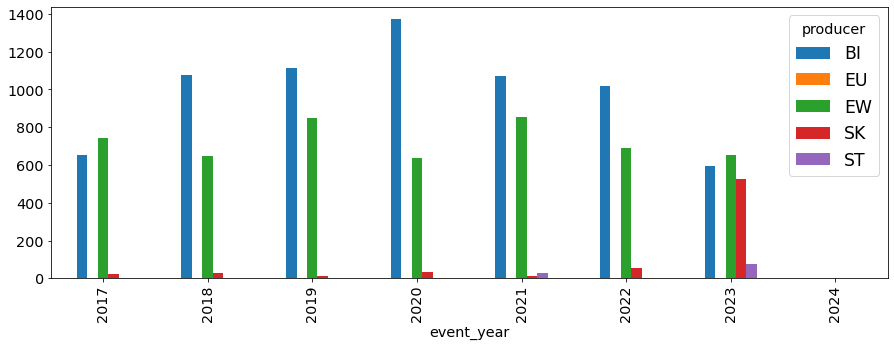

In [18]:
pivot.plot(kind='bar')

In [19]:
# change before merging

if True: # reduce number of locus_ids to 10 since OOM 
    locus_fix = np.array([3050332, 3047666, 3047806, 3050820, 3049901, 3051154, 3047034,
           3048582, 3049742, 3048644])

    feed_data = feed_data[feed_data['locus_id'].isin(locus_fix)]

In [20]:
feed_data['event_date'].max()

Timestamp('2024-01-02 00:00:00+0000', tz='UTC')

In [21]:
vaccines = pd.read_csv('../data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
#DE: changed to max here
vaccines_agg = vaccines.groupby('FINAL_LOCUS_POPULATION_ID')[['VAC_EVENT_DATE']].max(numeric_only=False)

In [22]:
vaccines_agg

,VAC_EVENT_DATE
FINAL_LOCUS_POPULATION_ID,
36778733,2017-07-12
36778768,2017-07-14
36778791,2017-07-18
36778910,2017-07-25
36778931,2017-07-25
...,...
194762173,2023-10-23
194762174,2023-10-23
194762175,2023-10-19


In [23]:
final_locus_locus_group_weighted

,final_locus_population_id,event_date,historic_locus_id,weight,locus_group_id
0,36770651,2015-05-15,3050549,1.0,535
1,36770651,2015-05-15,3050549,1.0,536
2,36770651,2015-05-16,3050549,1.0,535
3,36770651,2015-05-16,3050549,1.0,536
4,36770651,2015-05-17,3050549,1.0,535
...,...,...,...,...,...
104787572,194761283,2023-12-09,3048141,1.0,554
104787573,194761283,2023-12-09,3048141,1.0,559
104787574,194761283,2023-12-10,3048141,1.0,552
104787575,194761283,2023-12-10,3048141,1.0,554


In [24]:
#len(set(final_locus_locus_group_weighted.historic_locus_id)), len(set(feed_data.locus_id))

In [25]:
final_locus_locus_group_weighted['event_date'] = pd.to_datetime(final_locus_locus_group_weighted['event_date'], utc=True)
feed_data['event_date'] = pd.to_datetime(feed_data['event_date'], utc=True)

### To Final locus population level

In [26]:
if True:  # OOM, merge and save result to csv
    feed_data_final_lp = feed_data.merge(final_locus_locus_group_weighted,
                                         how='inner',
                                         left_on=['event_date', 'locus_id'],
                                         right_on=['event_date', 'historic_locus_id'])

In [27]:
feed_data_final_lp = feed_data_final_lp.merge(vaccines_agg,
                                              how='left',
                                              left_on='final_locus_population_id',
                                              right_index=True)

In [28]:
final_locus_population_transfer_dates = sw_fw_matching_with_cnt[['from_locus_population_id','transfer_date']]\
.groupby('from_locus_population_id').max()

feed_data_final_lp = feed_data_final_lp.merge(final_locus_population_transfer_dates,
                                     how='left',
                                     left_on='final_locus_population_id',
#                                      right_on='from_locus_population_id'
                                     right_index=True)

In [29]:
feed_data_final_lp['eight_weeks_before_transfer'] = feed_data_final_lp['transfer_date'] - pd.Timedelta(8,'w')

In [30]:
if False:
    label_enc = LabelEncoder()
    one_hot_enc = OneHotEncoder(sparse=False)
    encoded_manufacturer = one_hot_enc.fit_transform(
        label_enc.fit_transform(feed_data_final_lp['manufacturer']).reshape(-1, 1)
)

In [31]:
encoded_producer = pd.get_dummies(feed_data_final_lp['producer'])
feed_data_final_lp = feed_data_final_lp.drop('producer', axis=1)
feed_data_final_lp = feed_data_final_lp.join(encoded_producer)

In [32]:
feed_data_final_lp.groupby(['final_locus_population_id','event_date'])['weight'].sum().describe()

count    411193.000000
mean          0.088477
std           0.519396
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: weight, dtype: float64

In [33]:
feed_data_final_lp['event_year'] = feed_data_final_lp['event_date'].dt.year

for col in tqdm(encoded_producer.columns):
    feed_data_final_lp[f'weight_{col}'] = feed_data_final_lp['weight'] * feed_data_final_lp[col]

weighted_producer_cols = ['weight_' + col for col in encoded_producer.columns]
    
feed_data_final_lp_grouped = feed_data_final_lp.\
groupby(['final_locus_population_id','event_date'])[weighted_producer_cols].sum()

100%|██████████| 3/3 [00:00<00:00, 80.80it/s]


In [34]:
feed_data_final_lp['VAC_EVENT_DATE'] = pd.to_datetime(feed_data_final_lp['VAC_EVENT_DATE'], utc=True)
feed_data_final_lp['transfer_date'] = pd.to_datetime(feed_data_final_lp['transfer_date'], utc=True)
feed_data_final_lp['eight_weeks_before_transfer'] = pd.to_datetime(feed_data_final_lp['eight_weeks_before_transfer'], utc=True)

In [35]:
feed_data_final_lp_eight_last_weeks = feed_data_final_lp[
    feed_data_final_lp.event_date.between(
        feed_data_final_lp['eight_weeks_before_transfer'], feed_data_final_lp['transfer_date'])
]
feed_data_final_lp_vacc_transfer = feed_data_final_lp[
    feed_data_final_lp.event_date.between(
        feed_data_final_lp['VAC_EVENT_DATE'], feed_data_final_lp['transfer_date'])
]

feed_data_final_lp_grouped = feed_data_final_lp_grouped.reset_index()

In [36]:
feed_data_final_lp_grouped['weight_sum'] = feed_data_final_lp_grouped[weighted_producer_cols].sum(axis=1)

for col in weighted_producer_cols:
    feed_data_final_lp_grouped[col] = feed_data_final_lp_grouped[col] / feed_data_final_lp_grouped['weight_sum']

In [37]:
# for col in weighted_producer_cols:
#     sns.lineplot(data=feed_data_final_lp_grouped[feed_data_final_lp_grouped['final_locus_population_id'] == 36770651],
#                  x='event_date',
#                  y=col)

# plt.legend(weighted_producer_cols)

In [38]:
feed_data_final_lp_grouped['low_feeding_flag'] = (feed_data_final_lp_grouped['weight_sum'] < 0.5).astype(int)

#if have two records on feed with different mrts_feed_id in the same date
feed_data_final_lp_grouped['double_feeding_flag'] = (feed_data_final_lp_grouped['weight_sum'] > 1.5).astype(int)
feed_data_final_lp_grouped['multiple_feedings'] = ((feed_data_final_lp_grouped[weighted_producer_cols] != 0)\
.sum(axis=1) > 1).astype(int)

In [40]:
feed_data_final_lp_grouped['event_date'].max()

Timestamp('2023-10-20 00:00:00+0000', tz='UTC')

In [41]:
feed_producer_final_lp = feed_data_final_lp_grouped.groupby('final_locus_population_id').mean()

In [42]:
feed_producer_final_lp

,event_date,weight_BI,weight_EW,weight_SK,weight_sum,low_feeding_flag,double_feeding_flag,multiple_feedings
final_locus_population_id,,,,,,,,
36770651,2015-12-22 00:00:00+00:00,NaN,NaN,NaN,0.0,1.0,0.0,1.0
36770663,2015-12-22 00:00:00+00:00,NaN,NaN,NaN,0.0,1.0,0.0,1.0
36770708,2015-12-22 00:00:00+00:00,NaN,NaN,NaN,0.0,1.0,0.0,1.0
36770798,2015-12-22 00:00:00+00:00,NaN,NaN,NaN,0.0,1.0,0.0,1.0
36770840,2015-12-22 00:00:00+00:00,NaN,NaN,NaN,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
194761270,2023-06-03 12:00:00+00:00,NaN,NaN,NaN,0.0,1.0,0.0,1.0
194761272,2023-06-21 16:48:00+00:00,NaN,NaN,NaN,0.0,1.0,0.0,1.0
194761274,2023-06-03 12:00:00+00:00,NaN,NaN,NaN,0.0,1.0,0.0,1.0


### To locus_id level

In [43]:
key_columns = ['locus_id','fish_group_id','transfer_year']

mortality_cols = ['locus_id',
                  'fish_group_id',
                  'transfer_year',
                  'transfer_month',
                  'transfer_month_year',
                  'transfer_season',
                  'transfer_season2',
                  'total_count',
                  'total_mortality_perc_90']

sw_cols = ['to_locus_id',
           'to_fish_group_id',
           'transfer_date',
           'from_locus_population_id',
           'from_count_stocking',
           'transfer_year']

mortality_final_locus = mortality[mortality_cols].merge(
    sw_fw_matching_with_cnt[sw_cols],
    left_on=['fish_group_id', 'locus_id','transfer_year'],
    right_on=['to_fish_group_id', 'to_locus_id','transfer_year'],
    how='left'
)


mortality_final_locus['from_locus_population_id'] = mortality_final_locus['from_locus_population_id'].fillna(0).astype('int32')

In [44]:
feed_producer_final_lp = feed_producer_final_lp.merge(
    mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
    left_index=True,
    right_on=['from_locus_population_id',],
    how='right')
factors = feed_producer_final_lp.columns.difference(
    ['from_locus_population_id', 'locus_id', 'fish_group_id', 'transfer_year', 'from_count_stocking']
)

In [45]:
factors

Index(['double_feeding_flag', 'event_date', 'low_feeding_flag',
       'multiple_feedings', 'weight_BI', 'weight_EW', 'weight_SK',
       'weight_sum'],
      dtype='object')

In [46]:

feed_producer = create_factors_df(feed_producer_final_lp,
                                     factors.drop(['event_date']),
                                     key_columns, 
                                     weight_column='from_count_stocking',
                                     weighted_func=weighted_avg)
feed_producer = feed_producer.merge(
    pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
    on=key_columns,
    how='inner')

#feed_producer = feed_producer.merge(
#    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
#    on=key_columns,
#    how='inner'
#)


Weighting factors


100%|██████████| 7/7 [00:19<00:00,  2.75s/it]


In [47]:
feed_producer.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)
feed_producer.to_csv(f'../data/feed_producer_significant_factors.csv', index=False)

In [48]:
feed_producer

,locus_id,fish_group_id,transfer_year,double_feeding_flag,low_feeding_flag,multiple_feedings,weight_BI,weight_EW,weight_SK,weight_sum,mortality
0,3046036,11,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007496
1,3046036,1052,2019,0.0,1.0,1.0,NaN,NaN,NaN,0.0,0.003943
2,3046036,3918,2020,0.0,1.0,1.0,NaN,NaN,NaN,0.0,0.007676
3,3046036,6165,2023,0.0,1.0,1.0,NaN,NaN,NaN,0.0,0.005902
4,3046043,310,2017,0.0,1.0,1.0,NaN,NaN,NaN,0.0,0.018394
...,...,...,...,...,...,...,...,...,...,...,...
1402,7205278,6914,2023,0.0,1.0,1.0,NaN,NaN,NaN,0.0,0.009679
1403,7205279,6909,2023,0.0,1.0,1.0,NaN,NaN,NaN,0.0,0.007952
1404,7205280,6909,2023,0.0,1.0,1.0,NaN,NaN,NaN,0.0,0.015256
1405,7205281,6909,2023,0.0,1.0,1.0,NaN,NaN,NaN,0.0,0.007381


In [49]:
feed_producer.dropna(inplace=True)

feed_producer['highest_type'] = feed_producer[weighted_producer_cols].idxmax(axis=1)
feed_producer['highest_type'] = feed_producer['highest_type'].apply(lambda x: x.split('_')[-1])

<AxesSubplot:xlabel='highest_type', ylabel='mortality'>

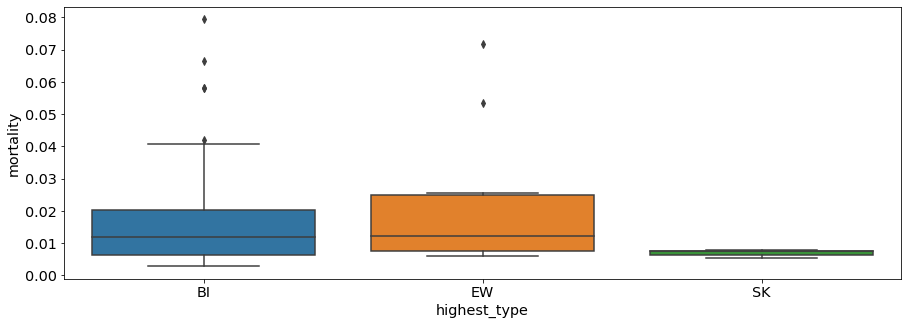

In [50]:
sns.boxplot(data=feed_producer, x='highest_type', y='mortality')